Building a PDF summarization Streamlit App by fine-tuning a T5-based model, 'LaMini-Flan-T5-248M', from the Hugging Face model hub

In [ ]:
!pip install langchain

In [ ]:
!pip install torch

In [ ]:
!pip install pybase64

In [ ]:
!pip install streamlit

In [ ]:
!pip install -U langchain-community

In [ ]:
!pip install transformers

In [ ]:
!pip install pypdf

In [ ]:
!pip install accelerate  # to optimize the model's performance

In [1]:
import streamlit as st

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.chains.summarize import load_summarize_chain

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline

In [4]:
import torch

In [5]:
import pybase64   # importing the pybase64 library for base64 encoding

## Tokenizer and Model

In [ ]:
checkpoint = "MBZUAI/LaMini-Flan-T5-248M"  # defining the checkpoint for the language model's from Hugging Face's Tranformer Library

# Load the tokenizer and model from the transformers library

tokenizer = T5Tokenizer.from_pretrained(checkpoint)
base_model = T5ForConditionalGeneration.from_pretrained(checkpoint, device_map = 'auto', torch_dtype = torch.float32)

## Preprocessing PDF files

In [ ]:
# Defining a function for preprocessing PDF files

def file_preprocessing(file):
  loader = pyPDFLoader(file)  # loads the PDF file
  pages = loader.load_and_split()  # splits the PDF into pages
  text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200, chunk_overlap = 50)  # initializes the text splitter with chunk size and overlap
  texts = text_splitter.split_documents(pages)  # splits the text into chunks
  final_texts = ""

# Concatenate the text chunks into a single string

  for text in texts:
    print(text)
    final_texts = final_texts + text.page_content
  return final_texts

## Pipeline

In [ ]:
# Creating a summarization pipeline using the specified model and tokenizer
# The summary will have a maximum length of 500 tokens and a minimum length of 50 tokens

def llm_pipeline(filepath):

  pipe_sum = pipeline(
      'summarization',
      model = base_model,
      tokenizer = tokenizer,
      max_length = 500,
      min_length = 50
  )

  input_text = file_preprocessing(filepath)  # preprocessing the input file to extract the text content
  result = pipe_sum(input_text)  # generates the summary using the summarization pipeline
  result = result[0]['summary_text']  # extracts the summary text from the result
  return result

## Display PDF in a Streamlit app code



In [6]:
%%writefile app.py

import streamlit as st
import tempfile
import os
import pybase64
import torch
import pypdf
from transformers import pipeline
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.chains.summarize import load_summarize_chain
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline

@st.cache_data  # caching data to improve performance

def displayPDF(file):

    with open(file, "rb") as f:
        base64_pdf = pybase64.b64encode(f.read()).decode('utf-8')

    # Embedding PDF in HTML
    pdf_display = F'<iframe src="data:application/pdf;base64,{base64_pdf}" width="100%" height="600" type="application/pdf"></iframe>'

    # Displaying File
    st.markdown(pdf_display, unsafe_allow_html=True)

st.set_page_config(layout="wide")  # configuring the Streamlit layout

# Loading the tokenizer and model for summarization
checkpoint = "MBZUAI/LaMini-Flan-T5-248M"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)
base_model = T5ForConditionalGeneration.from_pretrained(checkpoint, device_map = 'auto', torch_dtype = torch.float32)

# Preprocessing the PDF file
def file_preprocessing(file):
  loader = PyPDFLoader(file)
  pages = loader.load_and_split()
  text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200, chunk_overlap = 50)
  texts = text_splitter.split_documents(pages)
  final_texts = ""
  for text in texts:
    print(text)
    final_texts = final_texts + text.page_content
  return final_texts

# Loading the summarization pipeline
def llm_pipeline(filepath):

  pipe_sum = pipeline(
      'summarization',
      model = base_model,
      tokenizer = tokenizer,
      max_length = 500,
      min_length = 50
  )

  input_text = file_preprocessing(filepath)
  result = pipe_sum(input_text)
  result = result[0]['summary_text']
  return result

# Main function to run the Streamlit app for document summarization
def main():
    st.title("Document Summarization App using Langauge Model")  # setting the title of the Streamlit app

    uploaded_file = st.file_uploader("Upload your PDF file", type=['pdf'])  # creating a file uploader widget for uploading PDF files

    if uploaded_file is not None:   # checking if a file has been uploaded

        # Creating a temporary directory to store the uploaded file
        temp_dir = tempfile.mkdtemp()
        filepath = os.path.join(temp_dir, uploaded_file.name)

        # Saving the uploaded file to the temporary directory
        with open(filepath, "wb") as f:
                f.write(uploaded_file.getvalue())

        # Checking if the "Summarize" button is clicked
        if st.button("Summarize"):
            col1, col2 = st.columns(2)  # creating two columns for layout purposes

            with open(filepath, "wb") as temp_file:
                temp_file.write(uploaded_file.read())

            # Displaying the uploaded file in the first column
            with col1:
                st.info("Uploaded File")
                pdf_view = displayPDF(filepath)  # displays the PDF file on the left
            with col2:
                summary = llm_pipeline(filepath)  # generates the summary of the PDF file on the right
                st.info("Summarization Complete")
                st.success(summary)

if __name__ == "__main__":
    main()

Overwriting app.py


In [7]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.42s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [8]:
!streamlit run app.py & >/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.202.84.14



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.202.84.14:8501

npx: installed 22 in 4.735s
your url is: https://eight-donuts-listen.loca.lt
2024-05-30 13:28:38.174389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:28:38.174450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:28:38.176284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 13:28:40.087780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: 

In [ ]:
# Summarizing a research paper that I had done for a course

In [ ]:
!pip install matplotlib

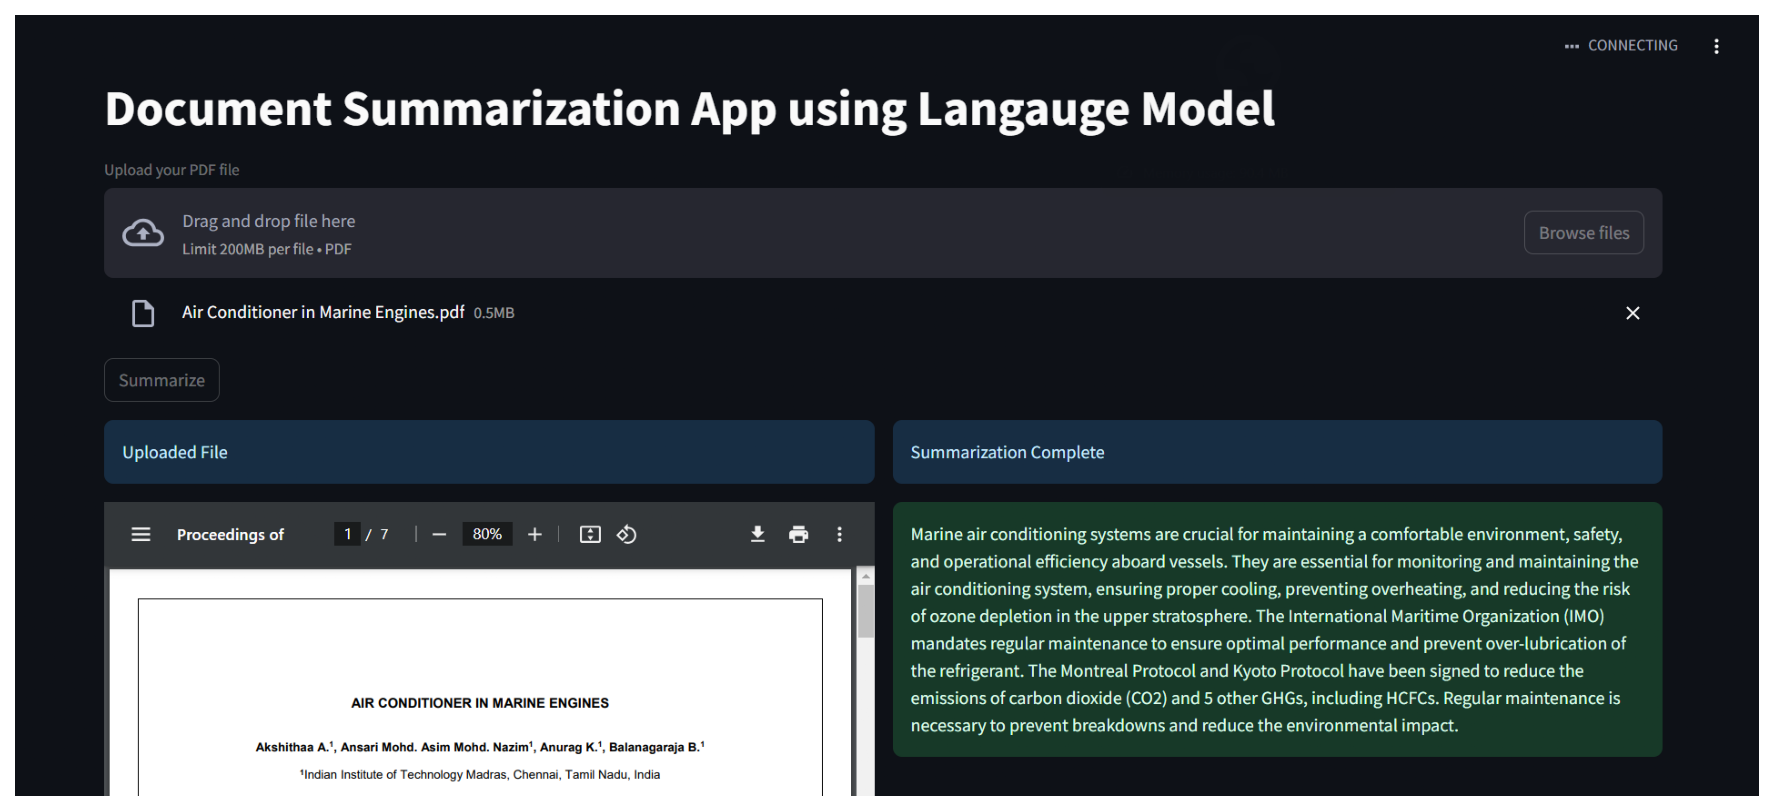

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('/content/Screenshot 2024-05-30 191505.png')


plt.figure(figsize=(15, 10), dpi=150)


plt.imshow(img)
plt.axis('off')
plt.show()